In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio


def plot_temperature(temperature):
    plt.imshow(temperature, cmap="hot", interpolation="nearest")
    plt.colorbar()
    plt.show()


def plot_grid(grid):
    plt.imshow(grid, cmap="tab20", interpolation="nearest")
    plt.colorbar()
    plt.show()


def plot_combined(temperature, grid, filename):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot temperature
    axs[0].imshow(temperature, cmap="hot", interpolation="nearest")
    axs[0].set_title("Temperature")
    fig.colorbar(axs[0].images[0], ax=axs[0])

    # Plot grid
    axs[1].imshow(grid, cmap="tab20", interpolation="nearest")
    axs[1].set_title("Grid")
    fig.colorbar(axs[1].images[0], ax=axs[1])

    # Save the combined plot as a PNG file
    plt.savefig(filename)
    plt.show()


def gen_gif(paths):
    images = []
    for path in paths:
        images.append(imageio.imread(path))
    imageio.mimsave("gif_path.gif", images, fps=2, format="GIF")

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import random


def initialize_grid(size, num_grains):
    grid = np.zeros((size, size), dtype=int)
    for _ in range(num_grains):
        x, y = random.randint(1, size - 2), random.randint(1, size - 2)
        grid[x, y] = random.randint(0, 19)  # _ + 1  # Assign unique grain ID
    return grid


def get_neighbors(grid, x, y):
    neighbors = []
    size = len(grid)
    for ndx in [-1, 0, 1]:
        for ndy in [-1, 0, 1]:
            if ndx == 0 and ndy == 0:
                continue
            nx = x + ndx
            ny = y + ndy
            if nx < 0 or nx >= size or ny < 0 or ny >= size:
                continue
            neighbors.append(grid[nx, ny])
    return neighbors


def update_grid(grid, temperature, dt):
    new_grid = grid.copy()
    for x in range(1, grid.shape[0] - 1):
        for y in range(1, grid.shape[1] - 1):
            if temperature[x, y] > 0.80:
                new_grid[x, y] = 0
                continue
            if grid[x, y] == 0:  # If cell is empty
                # adjust to dt
                # if random.random() > (dt * 100):
                #     continue
                if random.random() < ((1 - temperature[x, y] / 0.8) / 500):
                    new_grid[x, y] = random.randint(0, 19)
                neighbors = get_neighbors(grid, x, y)
                non_zero_neighbors = [n for n in neighbors if n != 0]
                if non_zero_neighbors:
                    # Temperature influences the probability of grain growth
                    if random.random() > (temperature[x, y] / 0.8):
                        new_grid[x, y] = random.choice(non_zero_neighbors)
    return new_grid

Adjusted dt for stability. New value dt=0.0025
(82, 82)


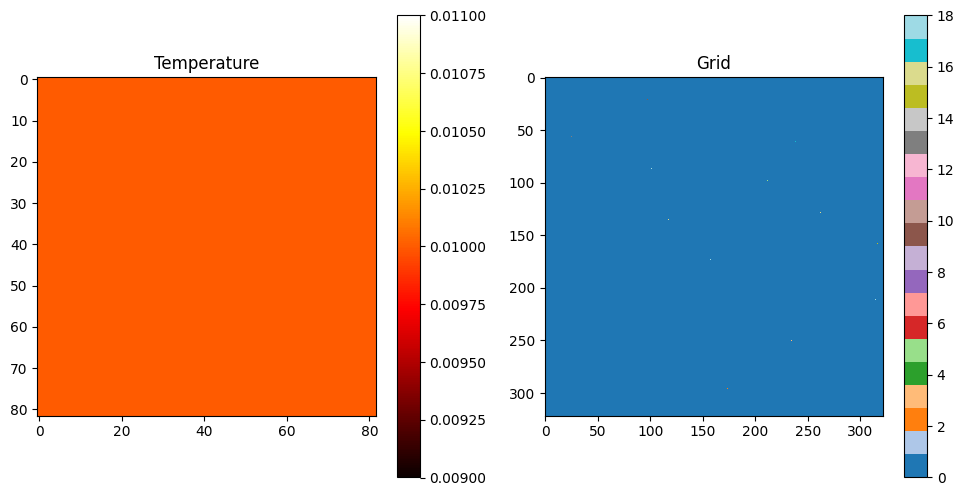

simulated for time 0


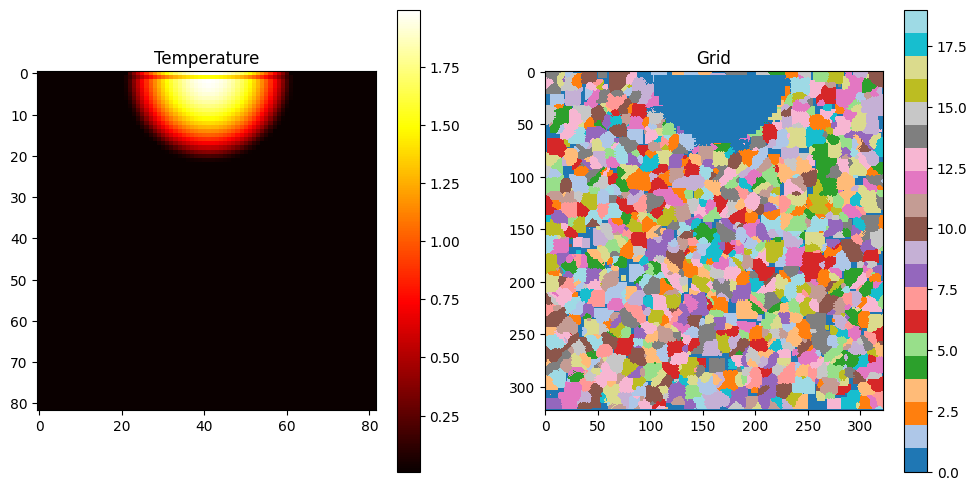

simulated for time 0.10250000000000005


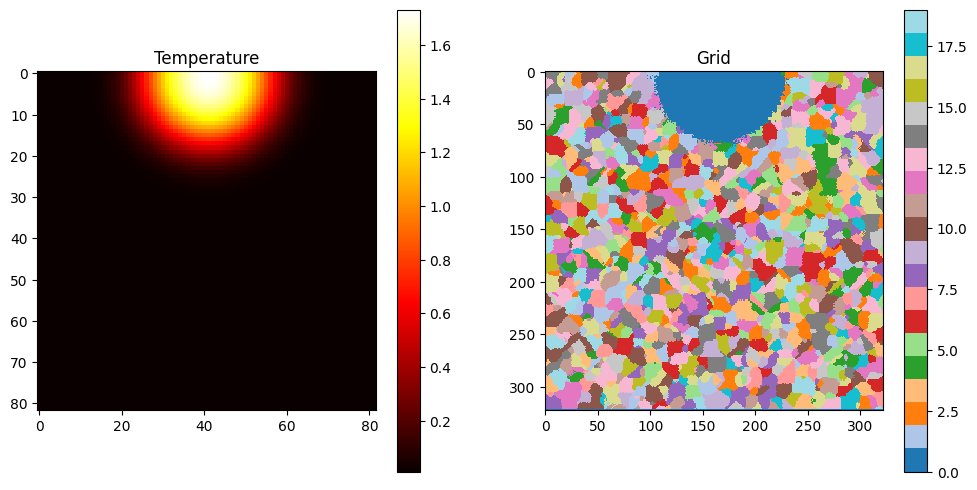

simulated for time 0.20500000000000013


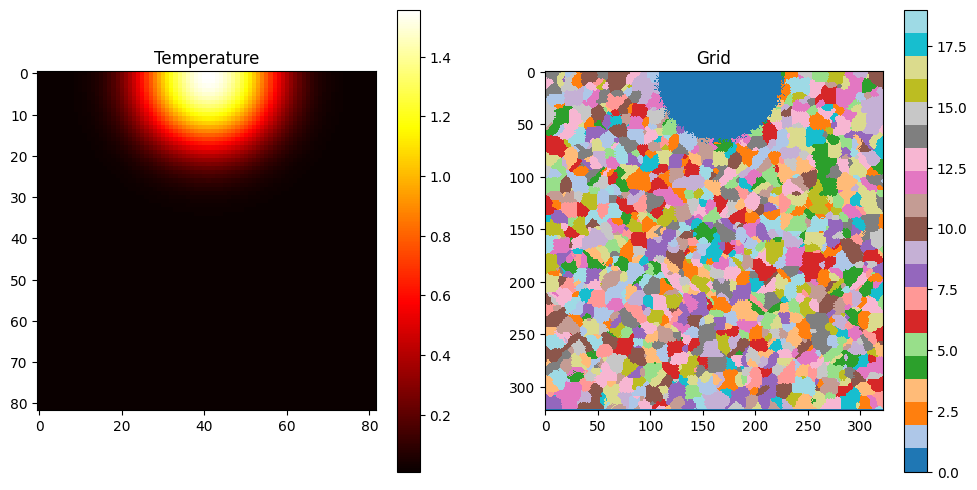

simulated for time 0.3075000000000002


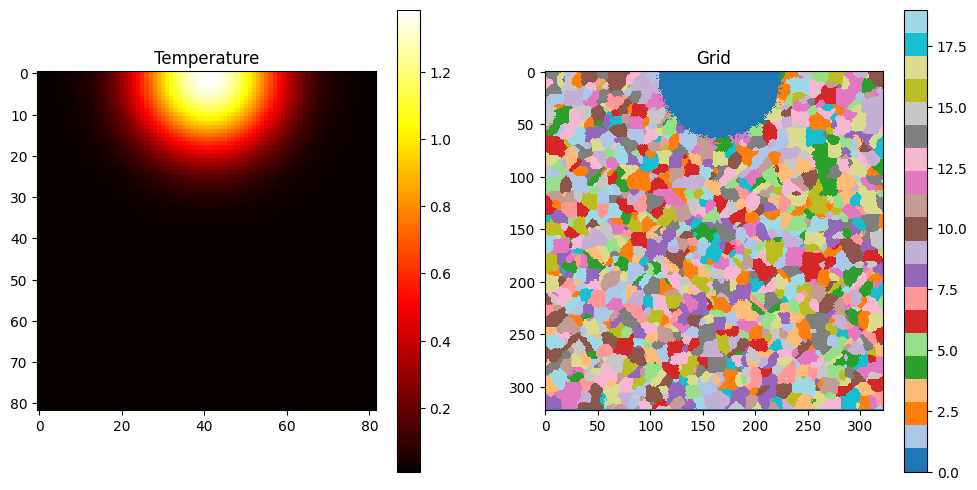

simulated for time 0.4100000000000003


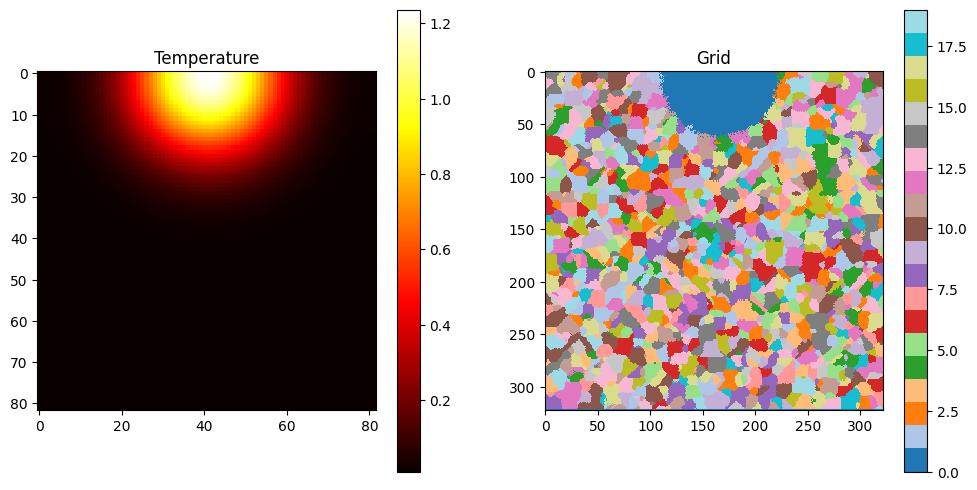

simulated for time 0.5125000000000001


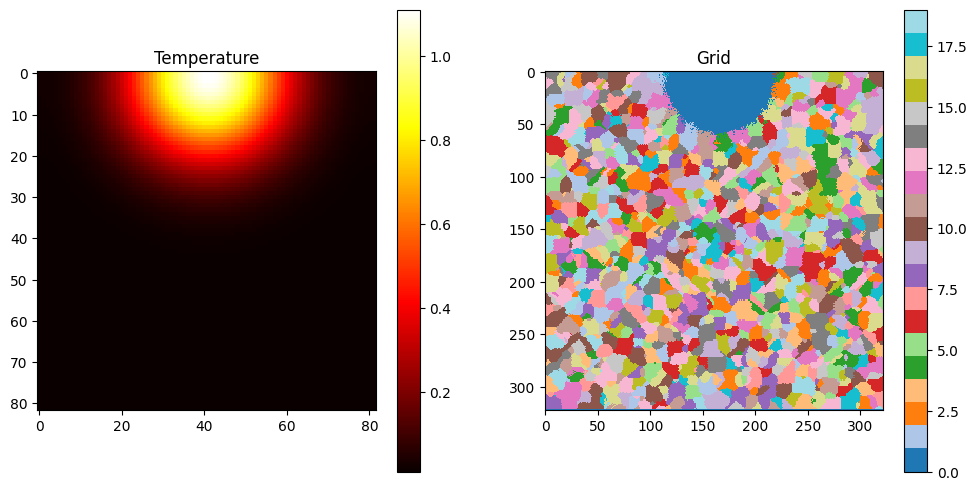

simulated for time 0.6149999999999979


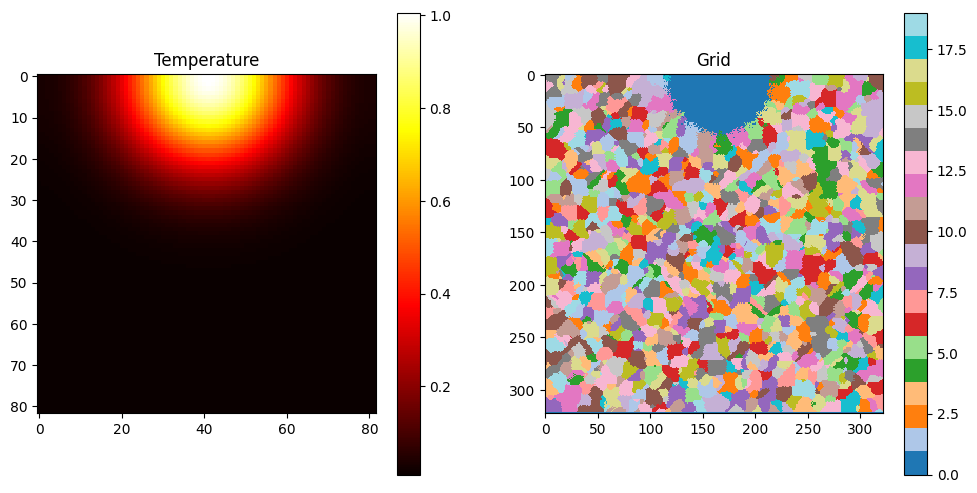

simulated for time 0.7174999999999957


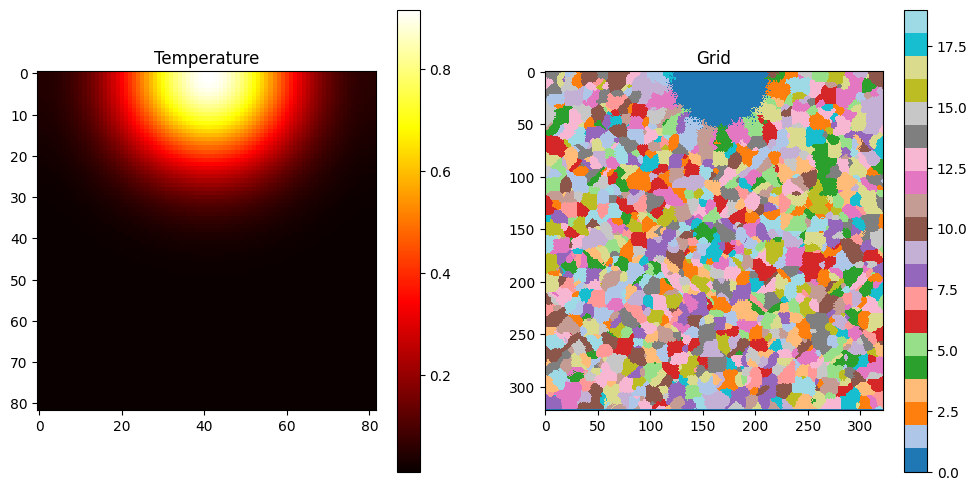

simulated for time 0.8199999999999935


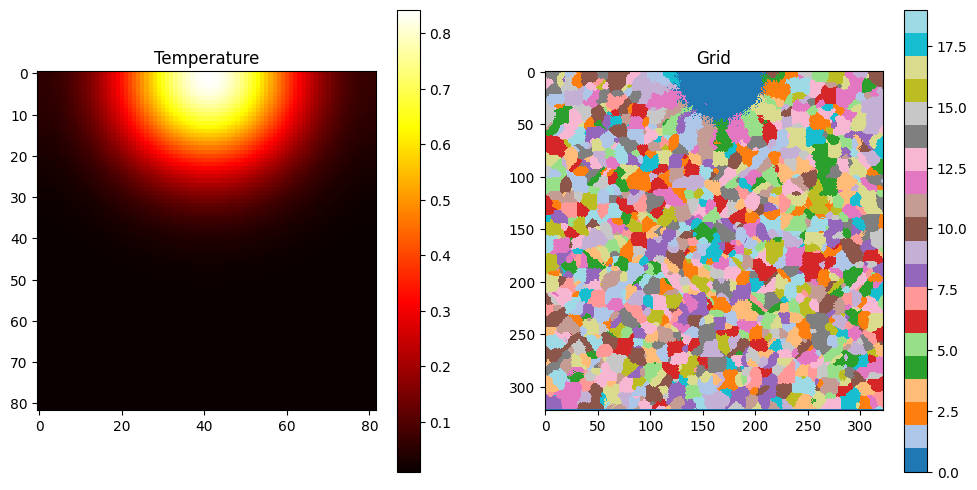

simulated for time 0.9224999999999913


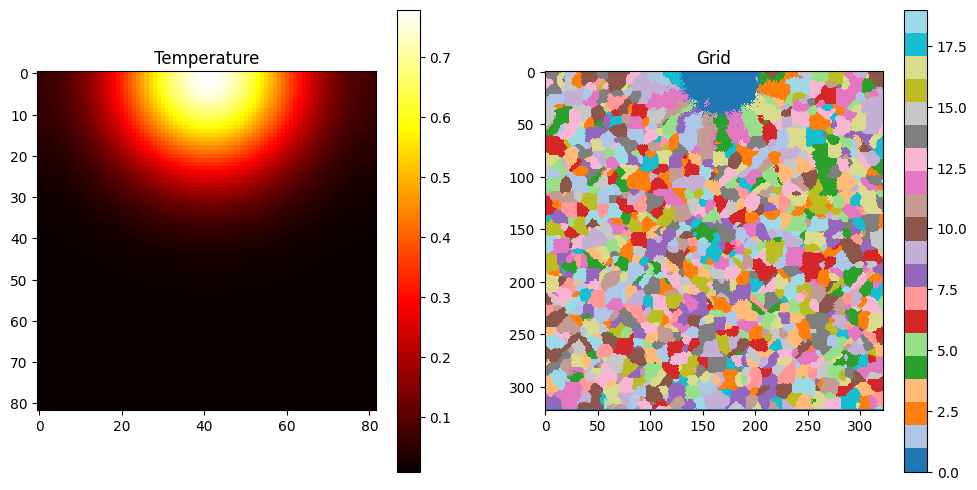

simulated for time 1.0249999999999893


KeyboardInterrupt: 

In [43]:
import numpy as np
import matplotlib.pyplot as plt

size = 80

points = [
    (0, size // 2, 0.1),
]

# Grid parameters
# length, width, height = 0.21, 0.31, 0.41  # dimensions of the rod. add 0.01 for di
dx, dy = 0.1, 0.1  # grid spacing in x, y, z
dt = 0.01  # time step

time = 0
end_time = 1.7

# Initial conditions
initial_temp = 2
air_temp = 0.01

# Material properties
k = 1  # thermal conductivity

if dt > 1 / (2 * k * (1 / dx / dx + 1 / dy / dy)):
    dt = 1 / (2 * k * (1 / dx / dx + 1 / dy / dy))
    print(f"Adjusted dt for stability. New value dt={dt}")


nx = ny = size


u = air_temp * np.ones((nx + 2, ny + 2))

print(u.shape)


# Apply boundary conditions
# Cold end boundary condition (example: all faces at one end)
# Air temperature boundary condition (example: all faces at the opposite end)
u[0, :] = air_temp  # 1100
u[:, 0] = air_temp
u[-1, :] = air_temp
u[:, -1] = air_temp


# Update temperature function for 2D
def update_temp_2d(u, dt, dx, dy, k):
    u_new = u.copy()
    y1 = u_new.shape[1] - 1
    for x1 in range(0, u_new.shape[0]):
        u_new[x1, y1] = min(u_new[x1, y1 - 1], u_new[x1, y1 - 2])
        u_new[x1, 0] = min(u_new[x1, 1], u_new[x1, 2])
    x2 = u_new.shape[0] - 1
    for y2 in range(0, u_new.shape[1]):
        u_new[x2, y2] = min(u_new[x1 - 1, y2], u_new[x1 - 2, y2])
        u_new[0, y2] = min(u_new[1, y2], u_new[2, y2])
    for i in range(1, u.shape[0] - 1):
        for j in range(1, u.shape[1] - 1):
            u_new[i, j] = u[i, j] + k * dt * (
                (u[i + 1, j] - 2 * u[i, j] + u[i - 1, j]) / dx**2
                + (u[i, j + 1] - 2 * u[i, j] + u[i, j - 1]) / dy**2
            )

    return u_new


def apply_heat(u, x, y, r):
    u_new = u.copy()
    for i in range(1, u.shape[0] - 1):
        for j in range(1, u.shape[1] - 1):
            if ((i - x) * (i - x) + (j - y) * (j - y)) <= r * r:
                u_new[i, j] = initial_temp - (initial_temp - air_temp) * (
                    ((i - x) * (i - x) + (j - y) * (j - y)) / (r * r)
                )

    return u_new


def expand_array(original_array, block_size=4):
    rows, cols = original_array.shape
    new_rows, new_cols = rows * block_size, cols * block_size

    # Initialize the new array with zeros or any default value
    expanded_array = np.zeros((new_rows, new_cols), dtype=original_array.dtype)

    for i in range(rows):
        for j in range(cols):
            # Fill the block with the value from the original array
            expanded_array[
                i * block_size : (i + 1) * block_size,
                j * block_size : (j + 1) * block_size,
            ] = original_array[i, j]

    return expanded_array


# def apply_heat(u, x, y, r):
#     u_new = u.copy()
#     for i in range(1, u.shape[1] - 1):
#         if ((i - y) * (i - y)) <= r * r:
#             u_new[x, i] = air_temp + (initial_temp - air_temp) * np.exp(
#                 -(((i - y) * (i - y)) / (r * r))
#             )

#     return u_new


n = 0

lastDrawN = 0
# lastCAN = 0
dtCA = 0.01
timeCA = 0
timeHeat = -1


grid = initialize_grid(size * 4 + 2, (size * size // 500))

img_paths = []

cur_path = f"{n}.png"
img_paths.append(cur_path)
plot_combined(u, grid, f"{n}.png")
print(f"simulated for time {time}")

lastHeatN = -100
lastHeatX = 0
lastHeatY = 0


# Simulation loop
while time < end_time:
    time += dt
    n += 1
    while points and (points[0][2] < time):
        lastHeatX, lastHeatY, t = points.pop(0)
        timeHeat = time
        # u = apply_heat(u, x + 1, y + 1, size)
        # grid = update_grid(grid, u, dt)
        # if time - timeHeat < 0.15:
        u = apply_heat(u, lastHeatX + 1, lastHeatY + 1, size // 4)
        grid = update_grid(grid, expand_array(u), dt)
    if time - timeCA > dtCA:
        timeCA += dtCA
        grid = update_grid(grid, expand_array(u), dt)
    if (n - lastDrawN) * dt > 0.1:
        lastDrawN = n
        cur_path = f"{n}.png"
        img_paths.append(cur_path)
        plot_combined(u, grid, f"{n}.png")
        print(f"simulated for time {time}")
    u = update_temp_2d(u, dt, dx, dy, k)

cur_path = f"{n}.png"
img_paths.append(cur_path)
plot_combined(u, grid, f"{n}.png")
print(f"simulated for time {time}")

gen_gif(img_paths)